In [1]:
import os
import numpy as np
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers.merge import _Merge
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
from keras import backend as K
from functools import partial
from PIL import Image

Using TensorFlow backend.


In [2]:
BATCH_SIZE = 64
DISCRIMINATOR_UPDATES_ITERS = 5  # number of discriminator updates per generator update
GP_WEIGHT = 10
EPOCHS_NUM = 100

OUTPUT_DIR = os.path.join("results", "convolutional_wgan_gp") 
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
CHECKPOINT_DIR = os.path.join("saved_models", "convolutional_wgan_gp", "checkpoints") 
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

In [3]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [4]:
def gp_loss(y_true, y_pred, averaged_samples, gp_weight):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    gradients_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = gp_weight * K.square(1 - gradients_l2_norm)
    return K.mean(gradient_penalty)

### Generator

In [5]:
def make_generator():
    model = Sequential()
    model.add(Dense(1024, input_dim=100))
    model.add(LeakyReLU())
    model.add(Dense(128 * 7 * 7))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 128), input_shape=(128 * 7 * 7,)))
    model.add(Conv2DTranspose(128, (5, 5), strides=2, padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(LeakyReLU())
    model.add(Convolution2D(64, (5, 5), padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=2, padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(LeakyReLU())
    model.add(Convolution2D(1, (5, 5), padding="same", activation="tanh"))
    return model

In [6]:
def make_discriminator():
    model = Sequential()
    model.add(Convolution2D(64, (5, 5), padding="same", input_shape=(28, 28, 1)))
    model.add(LeakyReLU())
    model.add(Convolution2D(128, (5, 5), kernel_initializer="he_normal", strides=[2, 2]))
    model.add(LeakyReLU())
    model.add(Convolution2D(128, (5, 5), kernel_initializer="he_normal", strides=[2, 2], padding="same"))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(1024, kernel_initializer="he_normal"))
    model.add(LeakyReLU())
    model.add(Dense(1, kernel_initializer="he_normal"))
    return model

In [7]:
def tile_images(image_stack):
    assert len(image_stack.shape) == 3
    image_list = [image_stack[i, :, :] for i in range(image_stack.shape[0])]
    tiled_images = np.concatenate(image_list, axis=1)
    return tiled_images

In [8]:
class RandomWeightedAverage(_Merge):
    def _merge_function(self, inputs):
        weights = K.random_normal((BATCH_SIZE, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

In [9]:
import json


def save_predicted_images(generator_model, output_dir, epoch):
    test_image_stack = generator_model.predict(np.random.normal(size=(20, 100)))
    test_image_stack = (test_image_stack * 127.5) + 127.5
    test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
    tiled_output = tile_images(test_image_stack)
    tiled_output = Image.fromarray(tiled_output, mode='L')  # L specifies greyscale
    outfile = os.path.join(output_dir, 'epoch_{}.png'.format(epoch))
    tiled_output.save(outfile)
    
def save_generator_model(generator_model, checkpoint_dir, epoch, frechet_distance):
    dir_path = os.path.join(checkpoint_dir, "Epoch_" + str(epoch))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        
    fd_json = {"frechet_distance": frechet_distance}
    with open(os.path.join(dir_path, "frechet_distance.json"), "w") as f:        
        json.dump(fd_json, f, indent=4)
    
    generator_model.save(os.path.join(dir_path, "generator_model.h5"))

### First we load the image data, reshape it and normalize it to the range [-1, 1]

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.concatenate((x_train, x_test), axis=0)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

div_coeff = 5 / 6
train_num = int(len(x_train) * div_coeff)
_x_train, x_fid_test = x_train[:train_num - 1], x_train[train_num:]
x_train = _x_train

In [11]:
generator = make_generator()
discriminator = make_discriminator()

In [12]:
for layer in discriminator.layers:
    layer.trainable = False
    
discriminator.trainable = False

generator_input = Input(shape=(100,))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)
generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])

# We use the Adam paramaters from Gulrajani et al.
generator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)
generator_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         7276993   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 5336961   
Total params: 12,613,954
Trainable params: 7,263,937
Non-trainable params: 5,350,017
_________________________________________________________________


In [13]:
for layer in discriminator.layers:
    layer.trainable = True
    
for layer in generator.layers:
    layer.trainable = False
    
discriminator.trainable = True
generator.trainable = False

In [14]:
# The discriminator_model is more complex. It takes both real image samples and random
# noise seeds as input. The noise seed is run through the generator model to get
# generated images. Both real and generated images are then run through the discriminator.
real_samples = Input(shape=x_train.shape[1:])
generator_input_for_discriminator = Input(shape=(100,))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

# We also need to generate weighted-averages of real and generated samples,
# to use for the gradient norm penalty.
averaged_samples = RandomWeightedAverage()([real_samples, generated_samples_for_discriminator])
# We then run these samples through the discriminator as well. Note that we never
# really use the discriminator output for these samples - we're only running them to
# get the gradient norm for the gradient penalty loss.
averaged_samples_out = discriminator(averaged_samples)

# The gradient penalty loss function requires the input averaged samples to get
# gradients. However, Keras loss functions can only have two arguments, y_true and
# y_pred. We get around this by making a partial() of the function with the averaged samples here.
partial_gp_loss = partial(gp_loss, averaged_samples=averaged_samples, gp_weight=GP_WEIGHT)
# Functions need names or Keras will throw an error
partial_gp_loss.__name__ = 'gradient_penalty'

# Keras requires that inputs and outputs have the same number of samples. This is why
# we didn't concatenate the real samples and generated samples before passing them to
# the discriminator: If we had, it would create an output with 2 * BATCH_SIZE samples,
# while the output of the "averaged" samples for gradient penalty would have only BATCH_SIZE samples.

# If we don't concatenate the real and generated samples, however, we get three
# outputs: One of the generated samples, one of the real samples, and one of the
# averaged samples, all of size BATCH_SIZE.
discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator],
                            outputs=[discriminator_output_from_real_samples,
                                     discriminator_output_from_generator,
                                     averaged_samples_out])
# We use the Adam paramaters from Gulrajani et al. We use the Wasserstein loss for both
# the real and generated samples, and the gradient penalty loss for the averaged samples
discriminator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                            loss=[wasserstein_loss,
                                  wasserstein_loss,
                                  partial_gp_loss])
discriminator_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 28, 28, 1)    7276993     input_3[0][0]                    
__________________________________________________________________________________________________
random_weighted_average_1 (Rand (None, 28, 28, 1)    0           input_2[0][0]                    
                                                                 sequential_1[2][0]         

### Train the model

In [15]:
from sys import stdout
from collections import namedtuple
from tensorflow_gan.examples.mnist import util


# We make three label vectors for training. positive_y is the label vector for real
# samples, with value 1. negative_y is the label vector for generated samples, with
# value -1. The dummy_y vector is passed to the gradient_penalty loss function and is not used.
positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32)

discriminator_loss = []
generator_loss = []

n_batches = int(x_train.shape[0] // (BATCH_SIZE * DISCRIMINATOR_UPDATES_ITERS))
# print("Number of epochs: ", EPOCHS_NUM)
# print("Number of batches: ", n_batches)

epoch = 1
num_of_good_epochs = 0

frechet_distance_edges = [10, 7, 3, 1, 0.5, 0.1, 0.05, 0.01]
frechet_distance_checkpoints = []
FDCheckpoint = namedtuple("FDCheckpoint", ["dist", "done"])
for edge in frechet_distance_edges:
    frechet_distance_checkpoints.append(FDCheckpoint(dist=edge, done=False))
    
x_fid_test = tf.convert_to_tensor(x_fid_test, dtype=tf.float32)
    
while True:
#for epoch in range(EPOCHS_NUM):
    np.random.shuffle(x_train)
    minibatches_size = BATCH_SIZE * DISCRIMINATOR_UPDATES_ITERS
    for i in range(n_batches):
        discriminator_minibatches = x_train[i * minibatches_size: (i + 1) * minibatches_size]
        for j in range(DISCRIMINATOR_UPDATES_ITERS):
            image_batch = discriminator_minibatches[j * BATCH_SIZE: (j + 1) * BATCH_SIZE]
            noise = np.random.normal(size=(BATCH_SIZE, 100))
            discriminator_loss.append(
                discriminator_model.train_on_batch([image_batch, noise], [positive_y, negative_y, dummy_y]))
            
        generator_loss.append(generator_model.train_on_batch(np.random.normal(size=(BATCH_SIZE, 100)), positive_y))
        
        stdout.write("\rEpoch: [%d], Batch: [%d/%d], D_Loss: %.4f, G_Loss: %.4f" %
                     (epoch, i, n_batches, discriminator_loss[-1][-1], generator_loss[-1]))
        stdout.flush()
        
    if epoch % 5 == 0:
        save_predicted_images(generator, OUTPUT_DIR, epoch)

        generated_images = generator.predict(np.random.normal(size=(len(x_fid_test), 100)))
        generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)

        frechet_distance = util.mnist_frechet_distance(x_fid_test, generated_images)
        stdout.write("\nFID: %.4f" % frechet_distance)

        for checkpoint in frechet_distance_checkpoints:
            if checkpoint.done:
                continue

            if not checkpoint.done:
                if frechet_distance <= checkpoint.dist:
                    stdout.write("\n\nSAVING THE GENERATOR MODEL, FD: %.4f\n\n" % frechet_distance)
                    save_generator_model(generator, CHECKPOINT_DIR, epoch, frechet_distance)                    
                    checkpoint.done = True

        if frechet_distance <= 0.01:
            num_of_good_epochs += 1
            if num_of_good_epochs >= 4:
                break
        else:
            num_of_good_epochs = 0
    stdout.write("\n")
    epoch += 1

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: [1], Batch: [2/182], D_Loss: 11.4555, G_Loss: -5.9426

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: [1], Batch: [181/182], D_Loss: 0.5303, G_Loss: -7.34390
Epoch: [2], Batch: [181/182], D_Loss: 0.3464, G_Loss: -9.48341
Epoch: [3], Batch: [181/182], D_Loss: 0.2009, G_Loss: -4.82271
Epoch: [4], Batch: [181/182], D_Loss: 0.2891, G_Loss: -5.9333
Epoch: [5], Batch: [181/182], D_Loss: 0.2341, G_Loss: -4.3711
FID: 278.0664
Epoch: [6], Batch: [181/182], D_Loss: 0.3745, G_Loss: -5.7270
Epoch: [7], Batch: [181/182], D_Loss: 0.1956, G_Loss: -0.0095
Epoch: [8], Batch: [181/182], D_Loss: 0.3290, G_Loss: -0.5855
Epoch: [9], Batch: [181/182], D_Loss: 0.2574, G_Loss: -1.6399
Epoch: [10], Batch: [181/182], D_Loss: 0.2783, G_Loss: -0.4234
FID: 259.6205
Epoch: [11], Batch: [181/182], D_Loss: 0.2409, G_Loss: 1.09588
Epoch: [12], Batch: [181/182], D_Loss: 0.2356, G_Loss: -1.9068
Epoch: [13], Batch: [181/182], D_Loss: 0.2940, G_Loss: 3.47527
Epoch: [14], Batch: [181/182], D_Loss: 0.1905, G_Loss: 2.06736
Epoch: [15], Batch: [181/182], D_Loss: 0.1329, G_Loss: 3.68944
FID: 248.6759
Epoch: [16], Batch:

Epoch: [247], Batch: [181/182], D_Loss: 0.0986, G_Loss: -2.4127
Epoch: [248], Batch: [181/182], D_Loss: 0.0908, G_Loss: -3.5782
Epoch: [249], Batch: [181/182], D_Loss: 0.0689, G_Loss: -3.8268
Epoch: [250], Batch: [181/182], D_Loss: 0.0939, G_Loss: -3.2992
FID: 18.2353
Epoch: [251], Batch: [181/182], D_Loss: 0.0578, G_Loss: -5.6799
Epoch: [252], Batch: [181/182], D_Loss: 0.1780, G_Loss: -5.1222
Epoch: [253], Batch: [181/182], D_Loss: 0.1312, G_Loss: -5.0574
Epoch: [254], Batch: [181/182], D_Loss: 0.1681, G_Loss: -5.6793
Epoch: [255], Batch: [181/182], D_Loss: 0.0704, G_Loss: -4.2950
FID: 18.0787
Epoch: [256], Batch: [181/182], D_Loss: 0.0708, G_Loss: -5.0295
Epoch: [257], Batch: [181/182], D_Loss: 0.0849, G_Loss: -3.8920
Epoch: [258], Batch: [181/182], D_Loss: 0.1015, G_Loss: -3.4556
Epoch: [259], Batch: [181/182], D_Loss: 0.0972, G_Loss: -4.3845
Epoch: [260], Batch: [181/182], D_Loss: 0.0866, G_Loss: -5.6693
FID: 18.4391
Epoch: [261], Batch: [181/182], D_Loss: 0.1147, G_Loss: -2.9523
E

TypeError: can only concatenate str (not "int") to str

#### GENERATOR LOSS

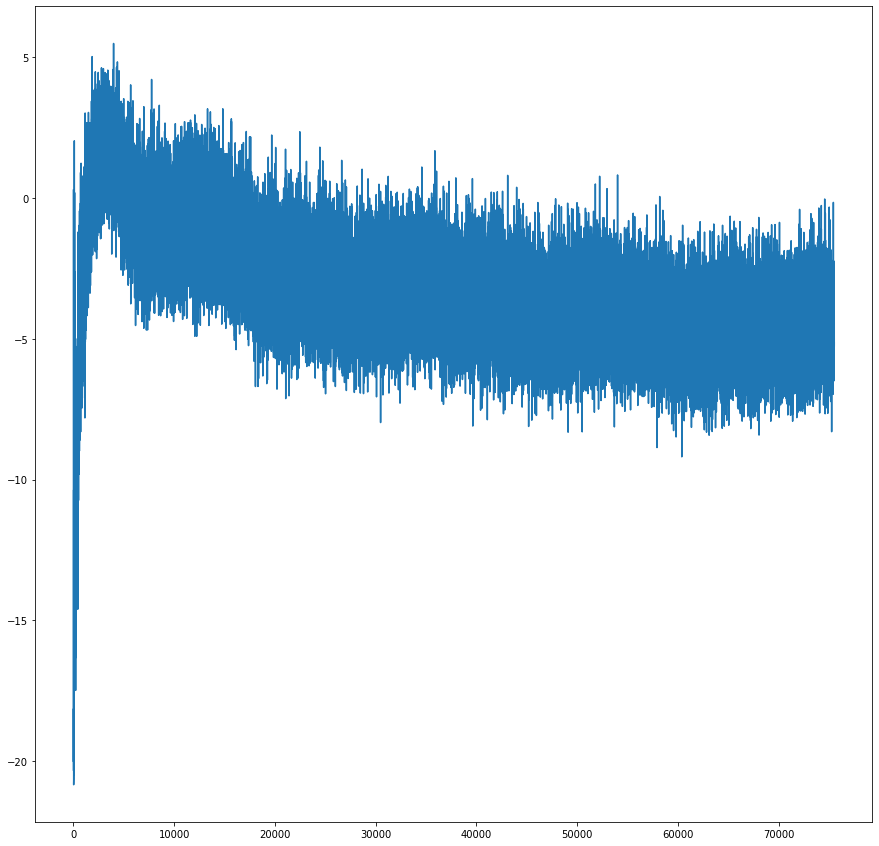

In [16]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(15, 15))
plt.plot(np.asarray(generator_loss))

#### DISCRIMINATOR LOSS

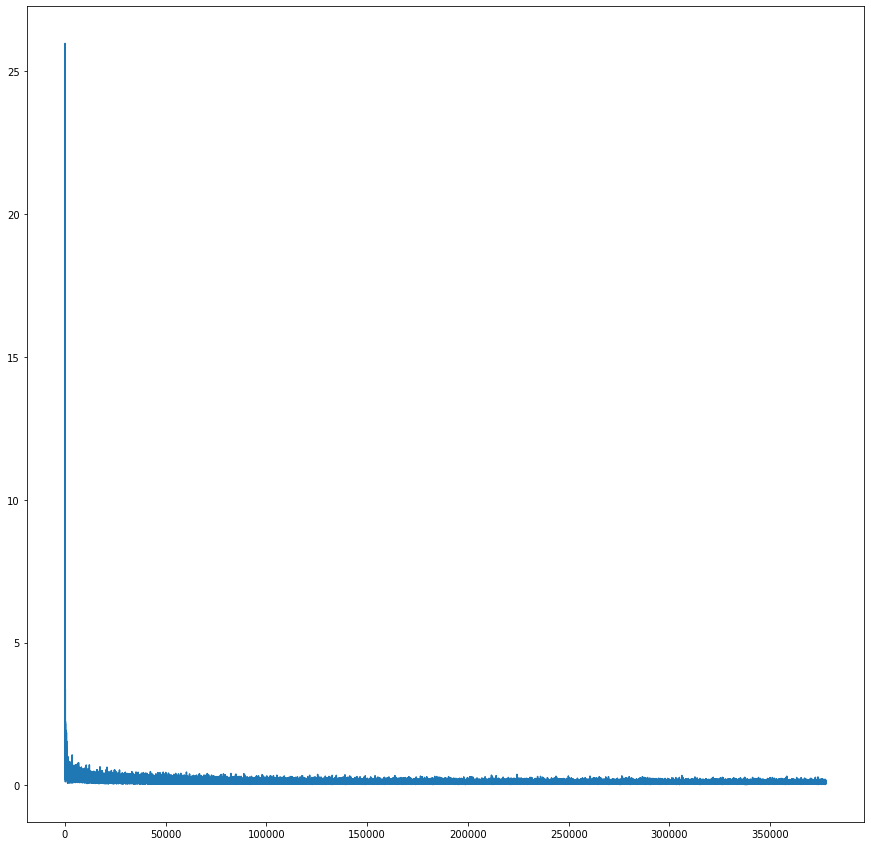

In [17]:
fig = plt.figure(figsize=(15, 15))
plt.plot(np.asarray([discriminator_loss_elem[-1] for discriminator_loss_elem in discriminator_loss]))

In [18]:
digit_size = 28
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    plt.figure(figsize=(2 * n, 2 * len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

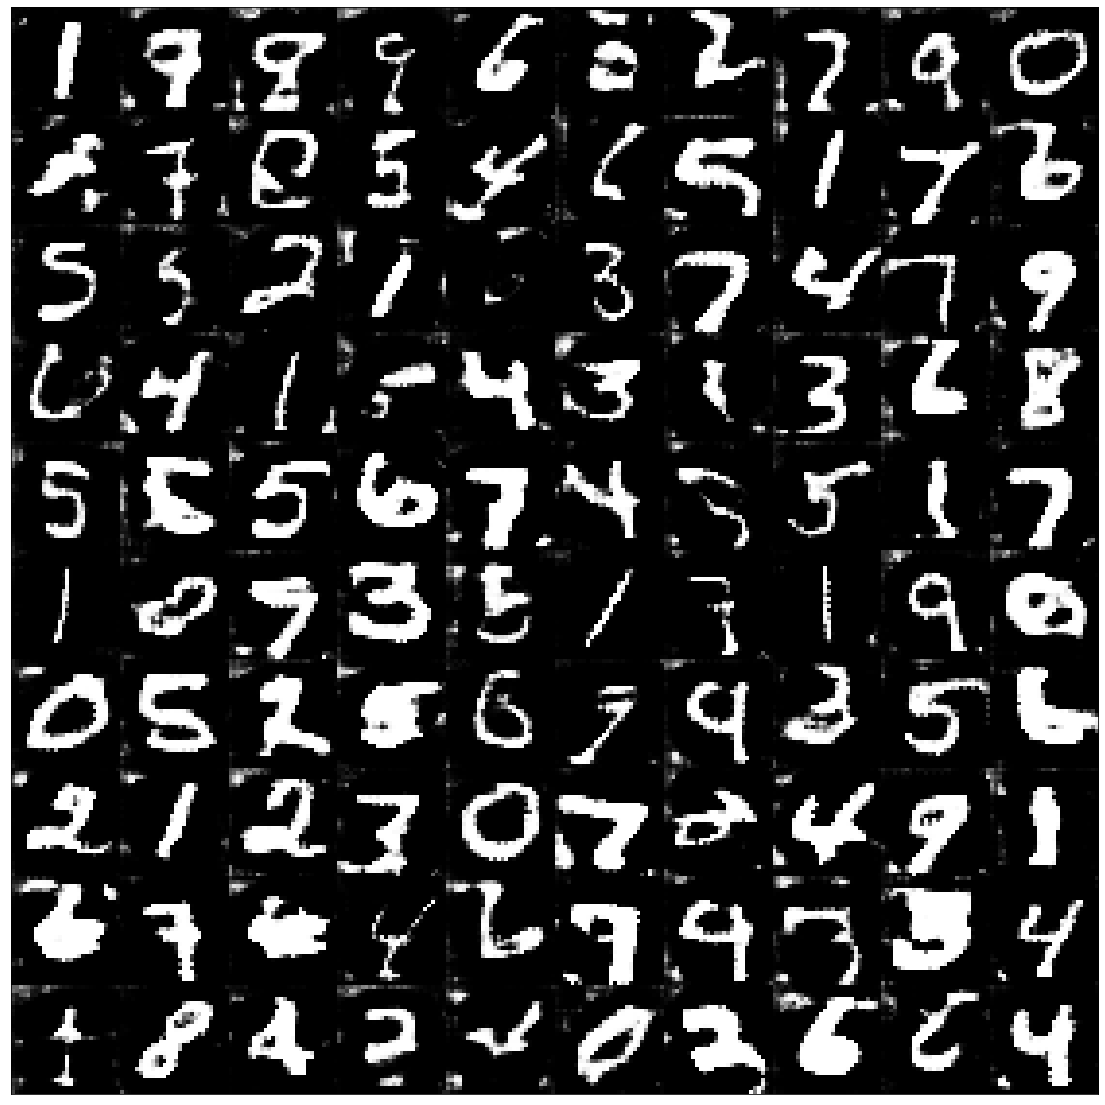

In [19]:
n_compare = 10
to_compare = []
for i in range(n_compare):
    codes = np.random.normal(size=(n_compare, 100))
    predicted = generator.predict(codes)
    to_compare.append(predicted)
plot_digits(*to_compare)